# Week 5: Introduction to Artificial Neural Networks

In this lab, you will learn how to use some basic elements of neural networks to create machine learning models, such as Multi-Layer Perceptron (MLP). Also, you will train the network and evaluate the trained model on a test set. We will again use MNIST as an example.

At the end of this lab, you will have a chance to design and train your network for a new classification task.

Let's first import some packages that will be used in this lab.

In [5]:
# Import packages:
# numpy: the fundamental package for scientific computing with Python
# os: miscellaneous operating system interfaces
# matplotlib: a package for plotting figures
# tqdm: a package the displays the progress of an iteration
# torch, torchvision: packages of PyTorch https://pytorch.org, a popular deep learning lib

import numpy as np
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

## Activation functions
Activation functions are mathematical equations that determine the output of a neural network. The function is attached to each neuron in the network, and determines whether it should be activated (“fired”) or not, based on whether each neuron’s input is relevant to the model’s prediction. Activation functions also help normalize the output of each neuron.

An additional aspect of activation functions is that they must be computationally efficient because they are calculated across thousands or even millions of neurons for each data sample. Modern neural networks use a technique called backpropagation to train the model, which places an increased computational strain on the activation function, and its derivative function.

Some popular activation functions and their derivatives are plotted.

In [6]:
# Define the Sigmoid and ReLU functions

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

# Obtain the derivatives of a function

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Now let's plot some activation functions and their derivatives.



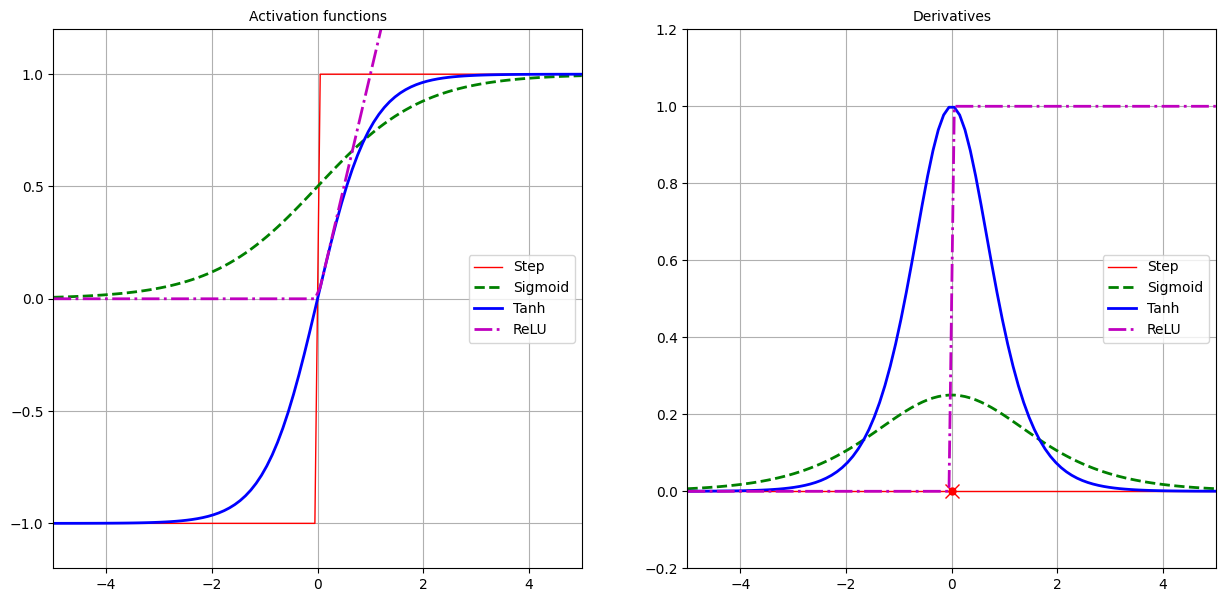

In [7]:
# Return a vector that contains 100 evenly spaced numbers over a specified interval [-5, 5].
# You can also try 5, 10 and 1000 numbers.
z = np.linspace(-5, 5, 100)

#figsize(float, float), default: rcParams["figure.figsize"] (default: [6.4, 4.8]) Width, height in inches.
plt.figure(figsize=(15,7))

# plot subfigures in a single figure. plt.subplot(x, y, z) means plot the zth subfigure of x * y subfigs
# more information about pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
# plot the curves of different avtivation functions
plt.subplot(1, 2, 1)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=10)
plt.title("Activation functions", fontsize=10)
plt.axis([-5, 5, -1.2, 1.2])

# plot the derivatives of different activation functions
plt.subplot(1, 2, 2)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=10)
plt.title("Derivatives", fontsize=10)
plt.axis([-5, 5, -0.2, 1.2])

# To plot pretty figures, you can change the fontsize and font style
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.show()

## NN for MNIST

In this section we will build an MLP with [Pytorch](https://pytorch.org/), and we will use the mini-batch stochastic gradient descent (SGD) optimiser to train it on the MNIST dataset. The first step is the construction phase, building the PyTorch [computational graph](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/). The second step is the training phase, where you actually run the graph to train the model.



We must specify the number of inputs and outputs, and set the number of hidden neurons in each layer. Each MNIST image has a size of 28 * 28 * 1. They are grey images with only a single colour channel. For each pixel in an image, its value ranges from 0 to 255, in the unit8 format. MNIST has 10 classes in total.

In [8]:
# Model/data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Define the transform that converts the data to tensors https://pytorch.org/docs/stable/tensors.html
# ToTensor converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the data: as MNIST is an inbuilt dataset in pytorch, we can load it using torchvision.datasets
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

x_train, y_train = train_data.data, train_data.targets
x_test, y_test = test_data.data, test_data.targets

# Alwasys check your training and test date before you design the network and train it
print("Training data shape: ", x_train.shape)
print(x_train.shape[0], "train samples \n")

print("Test data shape: ", x_test.shape)
print(x_test.shape[0], "test samples \n")

print("Training label shape: ", y_train.shape)
print(y_train.shape[0], "train labels \n")

print("Test label shape: ", y_test.shape)
print(y_test.shape[0], "test labels \n")

100%|██████████| 9912422/9912422 [00:07<00:00, 1245997.96it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 2095446.97it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1237864.61it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Training data shape:  torch.Size([60000, 28, 28])
60000 train samples 

Test data shape:  torch.Size([10000, 28, 28])
10000 test samples 

Training label shape:  torch.Size([60000])
60000 train labels 

Test label shape:  torch.Size([10000])
10000 test labels 



We will convert each sample to a vector with the size of 784 (28*28) and each label to a one-hot vector with the size of 10. In this one-hot vector, only the element of the correct class is 1. All the others are 0. Also, we will split the training data into training and validation sets.

In [9]:
# Warning: Do not run this code repetivelty as this may cause issues.
# If you do need to rerun this section, run the last section first and then run this section.

# Reshape the training and test data to matrics, each row is an image sample
# A tutorial for ndarray reshape https://www.w3schools.com/python/numpy/numpy_array_reshape.asp
x_train = x_train.view(-1, 28*28)
# x_train = x_train.reshape(-1, 28*28)
x_test = x_test.view(-1, 28*28)

# Convert class labels to one-hot vectors, each row is one
y_train = nn.functional.one_hot(y_train, num_classes=num_classes).numpy()
y_test = nn.functional.one_hot(y_test, num_classes=num_classes).numpy()


# Take 5000 samples from the training data as your validation set
x_valid, x_train = x_train[:5000], x_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

# Check your data again
print("Training data shape:", x_train.shape)
print("Validation data shape:", x_valid.shape)
print("Test data shape:", x_test.shape, "\n")

print("Training label shape:", y_train.shape)
print("Validation label shape:", y_valid.shape)
print("Test label shape:", y_test.shape)
valid_data, train_data = torch.utils.data.random_split(train_data, [5000, 55000])

Training data shape: torch.Size([55000, 784])
Validation data shape: torch.Size([5000, 784])
Test data shape: torch.Size([10000, 784]) 

Training label shape: (55000, 10)
Validation label shape: (5000, 10)
Test label shape: (10000, 10)


# Building a MLP with two hidden layers

The final output of the fully connected layer of a MLP is the logits, which should be further processed by the Softmax operation to get the probabality of each class.

Softmax is used for multi-class classification. Specifically, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.

For example, returning to the image analysis we saw in Figure 1, Softmax might produce the following likelihoods of an image belonging to a particular class:

![softmax](https://raw.githubusercontent.com/hqsiswiliam/surrey_ai_lab_dataset/master/SoftmaxLayer.svg)

- reference: [Multi-Class Neural Networks: Softmax](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax)

In PyTorch, the Softmax operation is included in the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss). So we do not add the Softmax layer to a network for multi-class classification.


In [11]:
# Set up the model size, as each image has 28*28 pixels in MNIST. The input should be 28*28.
# The output should have 10 neurons as we have 10 classes in MNIST.
# We use ReLU for hidden layers and Softmax for the last output layer.
# The sizes of the two hidden layers are set to 256 and 128. You can try more/fewer layers with different activation functions.

n_inputs = 28*28  # MNIST
n_hidden1 = 256
n_hidden2 = 128
n_outputs = 10

# Create the model
# The CrossEntropy loss in Pytorch includes softmax so you do not need SoftMax in your model
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden1, n_hidden2, n_outputs):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(n_inputs, n_hidden1)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden2, n_outputs)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        logits = self.fc3(x)
        return logits

# Instantiate the model
model = MLP(n_inputs, n_hidden1, n_hidden2, n_outputs)

# Print the model
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Now that we have the neural network model ready to go. We need to define the cost function that can be used to train the network. We will use the cross entropy loss. This loss penalizes a model that estimate a low probability for the target class.

In [12]:
# Define the loss function
crossentropy = nn.CrossEntropyLoss()

We have the neural network model, we have the cost function, and now we need to define an SGD optimizer that will tweak the model parameters to minimize the cost function.

In [13]:
# Set some hyperparameters and the evaluation metric
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


And now we can train the model:

In [14]:
# train the model with model.train(), or use the model to do prediction with model.eval().
# data_loader are created to provides an efficient and flexible way to load data into a model
# for training or inference.

epochs = 5
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Calculate the accuracy given a set of predicted outputs (logits) and the label
def accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    return correct / len(target)

# For loop over epoches
for epoch in range(epochs):
    model.train()

    # running loss and accuracy
    running_loss = 0.0
    running_accuracy = 0.0

    # For loop over mini batches
    for inputs, targets in tqdm(train_loader, desc = "Epoch-" + str(epoch)):
        # In pytorch, always set the gradients to zero for each mini batch
        optimizer.zero_grad()

        # Forward
        output = model(inputs.view(-1, 28*28))

        # Loss
        loss = crossentropy(output, targets)

        # Backward
        loss.backward()

        # Model parameters update
        optimizer.step()

        # Upate running loss and accuracy
        running_loss += loss.item()
        running_accuracy += accuracy(output, targets)

    print('Train - Loss: {:.6f}, Accuracy: {:.2f}%'.format(
        running_loss / len(train_loader), running_accuracy / len(train_loader) * 100))

    # Validation loop
    model.eval()
    valid_loss = 0
    valid_accuracy = 0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data.view(-1, 28*28))
            valid_loss += crossentropy(output, target).item()
            valid_accuracy += accuracy(output, target)

    print('Validation - Loss: {:.6f}, Accuracy: {:.2f}%\n'.format(
        valid_loss / len(valid_loader), valid_accuracy / len(valid_loader) * 100))

Epoch-0: 100%|██████████| 430/430 [00:07<00:00, 59.65it/s]


Train - Loss: 2.130729, Accuracy: 43.41%
Validation - Loss: 1.797606, Accuracy: 59.14%



Epoch-1: 100%|██████████| 430/430 [00:06<00:00, 63.35it/s]


Train - Loss: 1.232927, Accuracy: 72.33%
Validation - Loss: 0.835399, Accuracy: 80.12%



Epoch-2: 100%|██████████| 430/430 [00:06<00:00, 63.82it/s]


Train - Loss: 0.662107, Accuracy: 83.11%
Validation - Loss: 0.559625, Accuracy: 85.47%



Epoch-3: 100%|██████████| 430/430 [00:06<00:00, 64.02it/s]


Train - Loss: 0.492902, Accuracy: 86.89%
Validation - Loss: 0.454284, Accuracy: 87.50%



Epoch-4: 100%|██████████| 430/430 [00:06<00:00, 65.00it/s]


Train - Loss: 0.420321, Accuracy: 88.53%
Validation - Loss: 0.398658, Accuracy: 88.83%



The neural network is trained. You can use it to make predictions.

In [15]:
# Switch model to evaluation mode
model.eval()

# Perform inference on the test set
y_pred = []
with torch.no_grad():
    for data, _ in test_loader:
        output = model(data.view(-1, 28*28))
        _, predicted = torch.max(output, 1)
        y_pred.extend(predicted.numpy())

# Convert predicted labels to numpy array
y_pred = np.array(y_pred)

# Get the ground truth labels
y_test = test_data.targets.numpy()

# Print predicted and actual classes for the first 100 samples
print("Predicted classes of the first 100 samples:", y_pred[:100])
print("Actual classes of the first 100 samples: ", y_test[:100])

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
print("Total accuracy on the test set:", accuracy)

Predicted classes of the first 100 samples: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 4 2 7 4 2 4 3 0 7 0 2 7
 1 7 3 7 9 7 7 6 2 7 8 4 7 5 6 1 3 6 4 3 1 4 1 7 6 9]
Actual classes of the first 100 samples:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]
Total accuracy on the test set: 0.8935


## <font color='red'> Task1</font>

**Task 1:**

Create a new MLP model and train it on the MNIST dataset. Try to get more than 95% precision.

**This can be achieved by many ways. For examples:**
* You can try to add more layers.
* You can try the network for more epochs.
* You can try to use the Adam optimiser rather than SGD.
* And more ...


In [ ]:
# Add your code here

class MLP2(nn.Module):


# Instantiate the model
myModel = MLP2(... )

# Print the model
print(myModel)

# More code for training and testing




# Challenge Part: Tumour classification
We have a dataset containing measurements of breast tumours. This is a classification task.

- Labels:
  - 'B' for benign (noncancerous)
  - 'M' for malignant (cancerous)
- Notes:
  - You can use a loss function related to binary labels
  - Different activation functions might impact your model
  - You could look at feature-wise normalisation, which may help your model's performance, [using utility functions from scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html)

First, please download the dataset from SurreyLearn https://surreylearn.surrey.ac.uk/d2l/le/lessons/252865/lessons/2930200 and upload the COM2028_Week5_Lab_Data.zip file to the file folder of this notebook (left hand side).

In [ ]:
# unzip the compressed file to get the training and test data

!unzip COM2028_Week5_Lab_Data.zip

Now we can load the dataset using the pandas package.

In [ ]:
# pandas is a Python package that provides fast, flexible, and expressive data structures designed to make working with "relational" or "labeled" data both easy and intuitive.
# https://pypi.org/project/pandas/

import pandas as pd

# Use pandas to load a csv file
train_bc = pd.read_csv('COM2028_Week5_Lab_Data/BreastCancerTrain.csv')

print(f'Training set sample (target=weight): \n{train_bc[:10]}\n\n')

# Return all columns that are not the target, 'diagnosis', as a numpy array
X_train_bc = train_bc.loc[:, train_bc.columns != 'diagnosis'].values
X_train_bc = torch.from_numpy(X_train_bc)

print('Training sample shape', X_train_bc.shape, '\n Example:', X_train_bc[0])

# Return only the 'diagnosis' column as a numpy array
y_train_bc = train_bc.loc[:, 'diagnosis'].values

# Convert to binary labels
# You need to use the binary cross entropy loss for network training
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
# Please read and understand the differences

y_train_bc[y_train_bc == 'M'] = 1
y_train_bc[y_train_bc == 'B'] = 0

# Convert to tensor
y_train_bc = torch.from_numpy(y_train_bc.astype(np.int64))
print('Training target shape one-hot', y_train_bc.shape, '\n Example:', y_train_bc[0])

# Or, uncomment the code below if you want to use one-hot encoding as shown in the example code
# y_train_bc = nn.functional.one_hot(y_train_bc, num_classes = 2).numpy()
# print('Training target shape one-hot', y_train_bc.shape, '\n Example:', y_train_bc[0])




Now build your classifier and train it.

In [ ]:
# Your code here: build your NN classifier

# Set predictions to the output of your model
# predictions =

You will need to convert the output of your model to be 'M' or 'B' for each test sample. This depends on if you used boolean or one-hot encoding for the targets (or probabilities). You may need to adjust the examples below for your model.

In [ ]:
# Uncomment if you used one-hot encoding:
#final_predictions = ['M' if prediction == 1 else 'B' for prediction in np.argmax(predictions, axis=1)]

# Uncomment if you boolean encoding:
#final_predictions = ['M' if prediction == 1 else 'B' for prediction in predictions]


Now evaluate the performance of your model on the test set and calculate the precision (number of correct predictions/number of all test samples).

In [ ]:
# Add your code here




End of the notebook.

